# load numpy file and show image

In [1]:
from numpy import load
from matplotlib import pyplot

In [2]:
data = load('horse2zebra_256.npz')
dataA,dataB = data['arr_0'],data['arr_1']
print('Loaded: ',dataA.shape,dataB.shape)
n_samples = 3

Loaded:  (1187, 256, 256, 3) (1474, 256, 256, 3)


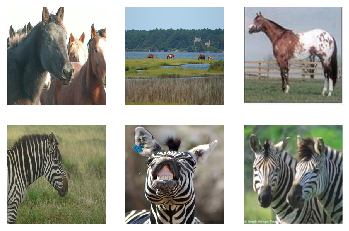

In [3]:
for i in range(n_samples):
    pyplot.subplot(2,n_samples,1+i)
    pyplot.axis('off')
    pyplot.imshow(dataA[i].astype('uint8'))
for i in range(n_samples):
    pyplot.subplot(2,n_samples,1+n_samples+i)
    pyplot.axis('off')
    pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

# using intel GPU

In [2]:
import os
import time
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#https://m.blog.naver.com/PostView.nhn?blogId=qbxlvnf11&logNo=221452760520&proxyReferer=https%3A%2F%2Fwww.google.com%2F

# using cycle GAN

In [3]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
#instanceNormalization 설명 -> https://blog.lunit.io/2018/04/12/group-normalization/
layer = InstanceNormalization(axis=-1)
#normalization 인자 설명 -> https://keras.io/ko/layers/normalization/

Using plaidml.keras.backend backend.


In [4]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from matplotlib import pyplot

# Discriminator

In [5]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02) # 설명->https://www.tensorflow.org/api_docs/python/tf/compat/v1/keras/initializers/RandomNormal
    in_image = Input(shape=image_shape)
    
    d = Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(in_image)
    #Conv2D 설명 -> https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/
    d = LeakyReLU(alpha=0.2)(d) #설명 -> https://excelsior-cjh.tistory.com/177
    
    d = Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    d = Conv2D(512,(4,4),padding='same',kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    patch_out = Conv2D(1,(4,4),padding='same',kernel_initializer=init)(d)
    
    model = Model(in_image,patch_out)
    
    model.compile(loss='mse',optimizer=Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])
    #optimizer 설명 -> https://gomguard.tistory.com/187
    #Adam 설명 -> https://light-tree.tistory.com/141
    #          -> https://keras.io/ko/optimizers/
    return model

In [6]:
def resnet_block(n_filters,input_layer):
    init = RandomNormal(stddev=0.02)
    
    g = Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    g = Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    
    g = Concatenate()([g,input_layer])
    return g

# Generator

In [7]:
def define_generator(image_shape, n_resnet = 9):
    init = RandomNormal(stddev=0.02)
    
    in_image = Input(shape=image_shape)
    
    g = Conv2D(64 ,(7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    g = Conv2D(128, (3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    g = Conv2D(256, (3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    for _ in range(n_resnet):
        g = resnet_block(256,g)
        
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    #Conv2DTranspose -> https://zzsza.github.io/data/2018/02/23/introduction-convolution/
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)

    model = Model(in_image, out_image)
    return model

# Composite model

In [8]:
def define_composite_model(g_model_1,d_model,g_model_2,image_shape):
    g_model_1.trainable=True
    d_model.trainable=False
    g_model_2.trainable=False
    
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    
    output_f = g_model_2(gen1_out)

    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    
    model = Model([input_gen,input_id],[output_d,output_id,output_f,output_b])
    
    opt = Adam(lr=0.0002,beta_1=0.5)
    
    model.compile(loss=['mse','mae','mae','mae'],loss_weights=[1,5,10,10],optimizer=opt)
    return model

# Make samples 

In [9]:
def load_real_samples(filename):
    data = load(filename)
    X1,X2 = data['arr_0'],data['arr_1']
    
    X1 = (X1 - 127.5)/127.5
    X2 = (X2 - 127.5)/127.5
    return [X1,X2]

def generate_real_samples(dataset,n_samples,patch_shape):
    ix = randint(0,dataset.shape[0],n_samples)
    
    X = dataset[ix]
    y = ones((n_samples,patch_shape,patch_shape,1))
    return X,y

def generate_fake_samples(g_model,dataset,patch_shape):
    X = g_model.predict(dataset)
    y = zeros((len(X),patch_shape,patch_shape,1))
    return X,y

def save_model(step,g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1,filename2))

# performance

In [10]:
def summarize_performance(step,g_model,trainX,name,n_samples =5):
    X_in, _ = generate_real_samples(trainX,n_samples,0)
    X_out, _ = generate_fake_samples(g_model,X_in,0)
    
    X_in = (X_in + 1)/2.0
    X_out = (X_out+1)/2.0
    
    for i in range(n_samples):
        pyplot.subplot(2,n_samples,1+i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    for i in range(n_samples):
        pyplot.subplot(2,n_samples,1+n_samples+i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    
    filename1 = '%s_generated_plot_%06d.png' % (name,(step+1))
    pyplot.savefig(filename1)
    pyplot.close()

# ???

In [11]:
def update_image_pool(pool,images,max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = randint(0,len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

# Train

In [12]:
def train(d_model_A,d_model_B,g_model_AtoB,g_model_BtoA,c_model_AtoB,c_model_BtoA,dataset):
    n_epochs,n_batch, = 100,1
    n_patch = d_model_A.output_shape[1]
    
    trainA,trainB = dataset
    poolA,poolB = list(), list()
    
    bat_per_epo = int(len(trainA)/n_batch)
    
    n_steps = bat_per_epo * n_epochs
    
    for i in range(n_steps):
        X_realA,y_realA = generate_real_samples(trainA,n_batch,n_patch)
        X_realB,y_realB = generate_real_samples(trainB,n_batch,n_patch)
        
        X_fakeA,y_fakeA = generate_fake_samples(g_model_BtoA,X_realB,n_patch)
        X_fakeB,y_fakeB = generate_fake_samples(g_model_AtoB,X_realA,n_patch)
        
        X_fakeA = update_image_pool(poolA,X_fakeA)
        X_fakeB = update_image_pool(poolB,X_fakeB)
        
        g_loss2,_,_,_,_ = c_model_BtoA.train_on_batch([X_realB,X_realA],[y_realA,X_realA,X_realB,X_realA])
        
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        
        g_loss1,_,_,_,_ = c_model_AtoB.train_on_batch([X_realA,X_realB],[y_realB,X_realB,X_realA,X_realB])
        
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB,y_fakeB)
        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i,g_model_AtoB,trainA,'AtoB')
            summarize_performance(i,g_model_BtoA,trainB,'BtoA')
        if (i+1) % (bat_per_epo *5) == 0:
            sae_models(i,g_model_AtoB,g_model_BtoA)
        

In [13]:
dataset = load_real_samples('horse2zebra_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (1187, 256, 256, 3) (1474, 256, 256, 3)


In [14]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

>1, dA[1.896,0.859] dB[1.743,1.095] g[19.028,19.971]
>2, dA[2.929,2.497] dB[1.410,1.108] g[19.230,20.139]
>3, dA[6.896,1.403] dB[2.345,2.811] g[19.001,17.200]
>4, dA[14.260,1.300] dB[2.029,1.670] g[19.040,21.236]
>5, dA[4.239,0.924] dB[3.046,3.483] g[16.510,16.857]
>6, dA[1.631,0.678] dB[1.207,2.110] g[18.860,18.202]
>7, dA[1.554,1.165] dB[2.145,1.024] g[16.748,16.287]


KeyboardInterrupt: 